In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import joblib

In [2]:
sns.set_theme()

In [3]:
df_nat = pd.read_parquet('national_games.parquet')
df_leag = pd.read_parquet('league_games.parquet')

In [4]:
df = pd.concat([df_nat, df_leag], ignore_index=True)

In [5]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split
import lightgbm as lgb
from scipy.stats import uniform, loguniform, randint
from sklearn.metrics import ConfusionMatrixDisplay

In [11]:
x_cols = ['overall', 'potential', 'skill_moves', 'attacking_finishing', 
          'skill_long_passing', 'movement_sprint_speed', 'movement_agility', 
          'value_eur', 'wage_eur', 'attacking_finishing', 'power_stamina']
x_cols = [s + a for s in x_cols  for a in ['_min', '_mean', '_max']]
x_cols = x_cols + ['goalkeeping_positioning_max', 'goalkeeping_reflexes_max']
x_cols = [t + s for t in ['team1_', 'team2_'] for s in x_cols]
y_col = ['team1_score']

In [12]:
x = df[x_cols].values
y = df[y_col].values.ravel()
y[y > 5] = 5

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y)

In [15]:
def transform_cv_results(res):
    d = {'fit_time': res['mean_fit_time']}
    for (k, v) in res.items():
        if k.startswith('param_'):
            d[k[6:]] = v
    for (k, v) in res.items():
        if k.startswith('mean_test_'):
            d[k[10:]] = v
    for (k, v) in res.items():
        if k.startswith('rank_test_'):
            d[k[10:] + '_rank'] = v
    return pd.DataFrame(d)

In [16]:
model = lgb.LGBMClassifier(class_weight='balanced')
grid_params = {
    'n_estimators': randint(700, 1200),
    'learning_rate': loguniform(0.005, 0.02),
    'max_depth': randint(7, 11),
    'num_leaves': 2 ** np.arange(5, 8),
    'colsample_bytree': uniform(0.01, 0.5)
}
scores = {'balanced_accuracy': 'balanced_accuracy', 'f1_weighted': 'f1_weighted',
    'roc_auc_ovr_weighted': 'roc_auc_ovr_weighted'}
clf = RandomizedSearchCV(model, grid_params, n_iter=100, scoring=scores, refit='f1_weighted')
search = clf.fit(x_train, y_train)

In [17]:
res = transform_cv_results(clf.cv_results_)

In [34]:
res.sort_values('f1_weighted_rank')

,fit_time,colsample_bytree,learning_rate,max_depth,n_estimators,num_leaves,balanced_accuracy,f1_weighted,roc_auc_ovr_weighted,balanced_accuracy_rank,f1_weighted_rank,roc_auc_ovr_weighted_rank
59,10.614483,0.066566,0.012932,10,1067,64,0.216819,0.300684,0.569520,73,1,66
71,11.724659,0.064785,0.019609,10,733,128,0.208594,0.299626,0.563129,94,2,94
7,9.906502,0.415961,0.019017,9,1089,32,0.214293,0.299485,0.567458,81,3,78
31,19.246020,0.182715,0.007614,10,1151,128,0.211101,0.299429,0.566634,90,4,86
23,14.843153,0.456038,0.010623,9,963,64,0.217694,0.299104,0.567862,72,5,76
...,...,...,...,...,...,...,...,...,...,...,...,...
97,4.884886,0.033347,0.008556,9,904,32,0.245489,0.279971,0.574128,11,96,26
9,6.582698,0.022971,0.005452,8,735,64,0.245898,0.279438,0.572479,9,97,47
60,6.055071,0.014758,0.018737,9,1173,32,0.238865,0.270780,0.567269,20,98,79
63,5.325114,0.013639,0.006803,8,1045,32,0.247339,0.267084,0.566009,6,99,88


In [19]:
clf.best_params_

{'colsample_bytree': 0.06656612299768393,
 'learning_rate': 0.012932366040730224,
 'max_depth': 10,
 'n_estimators': 1067,
 'num_leaves': 64}

In [37]:
best_model = clf.best_estimator_

In [38]:
joblib.dump(best_model, 'lgbm_model.joblib')

['lgbm_model.joblib']

In [28]:
params = {
    'n_estimators': 763,
    'learning_rate': 0.0055,
    'max_depth': 7,
    'num_leaves': 32,
    'colsample_bytree': 0.37,
    'class_weight': 'balanced'
}
best_model = lgb.LGBMClassifier(**params)

In [39]:
best_model.fit(x_train, y_train)

LGBMClassifier(class_weight='balanced', colsample_bytree=0.06656612299768393,
               learning_rate=0.012932366040730224, max_depth=10,
               n_estimators=1067, num_leaves=64)

In [40]:
y_hat = best_model.predict(x_test)

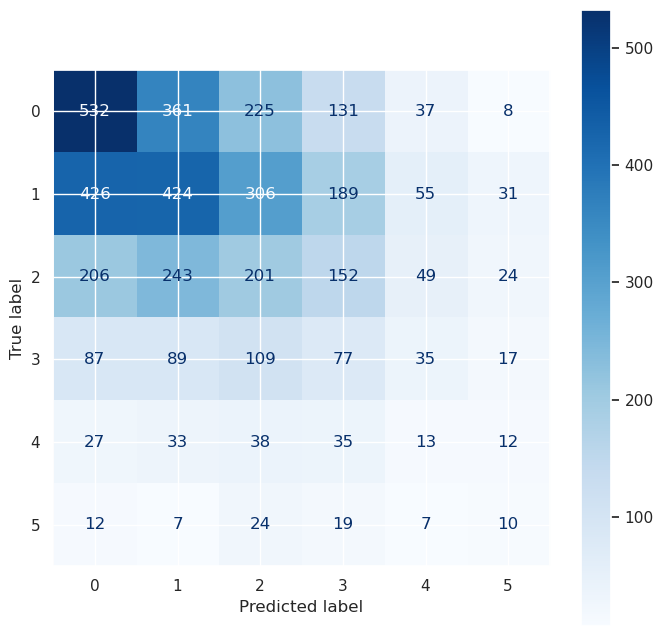

In [41]:
fig, ax = plt.subplots(figsize=(8, 8))
ConfusionMatrixDisplay.from_predictions(y_test, y_hat, ax=ax, cmap='Blues')

In [42]:
test = pd.DataFrame({'y': y_test, 'y_hat': y_hat})

<AxesSubplot:xlabel='y', ylabel='y_hat'>

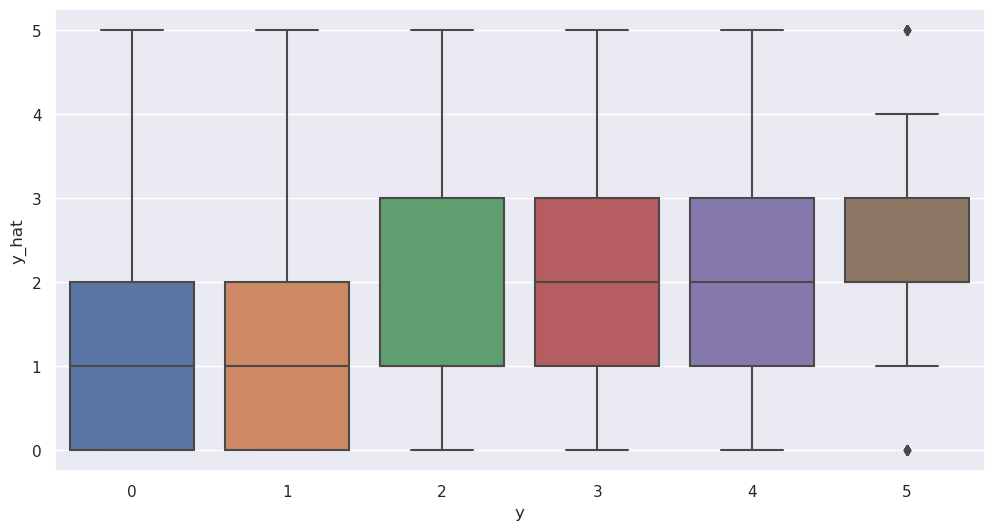

In [43]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(ax=ax, data=test, y='y_hat', x='y')

In [44]:
bins = (-0.5, 0.5, 0.5, 1.5, 1.5, 2.5, 2.5, 3.5, 3.5, 4.5, 4.5, 5.5, 5.5)

<AxesSubplot:ylabel='Count'>

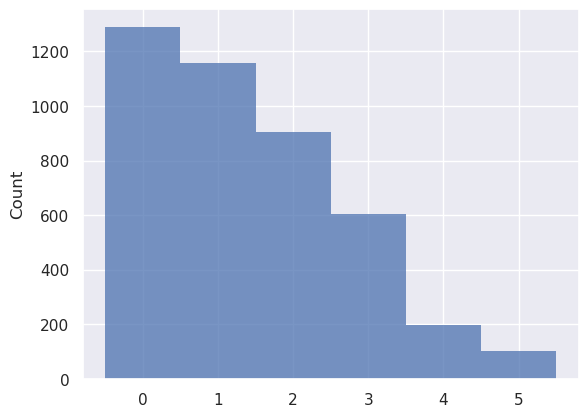

In [45]:
sns.histplot(y_hat, bins=bins)

<AxesSubplot:ylabel='Count'>

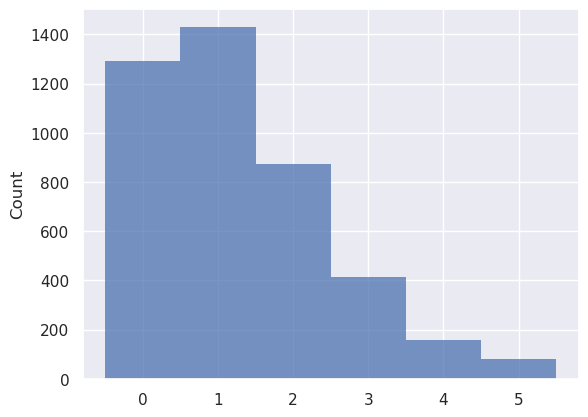

In [46]:
sns.histplot(y_test, bins=bins)

In [102]:
def merge_wc22_teams(res, teams):
    match_list = []
    val_cols = [c for c in teams.columns if c not in ['year', 'team']]
    col_names = ['team1_' + c for c in val_cols] + ['team2_' + c for c in val_cols]
    for row in res.itertuples(index=False):
        team1 = row.team1
        team2 = row.team2
        col_vals = np.hstack((
            teams[teams['team'] == team1].sort_values('year').iloc[-1][val_cols].values,
            teams[teams['team'] == team2].sort_values('year').iloc[-1][val_cols].values
        ))
        d = {col_name: col_val for (col_name, col_val) in zip(col_names, col_vals)}
        d['team1'] = team1
        d['team2'] = team2
        match_list.append(d)
    return pd.DataFrame(match_list)

def transform_wc22(df):
    df = df[df['Team1_Name'] != '-']
    team1 = np.hstack((df['Team1_Name'].values, df['Team2_Name'].values))
    team2 = np.hstack((df['Team2_Name'].values, df['Team1_Name'].values))
    df = pd.DataFrame({'team1': team1, 'team2': team2})
    df['team1'] = df['team1'].astype('string')
    df['team2'] = df['team2'].astype('string')
    df = df.replace({'IR Iran': 'Iran', 'South Korea': 'Korea Republic', 'USA': 'United States'})
    return df

def predict_wc22(model, df):
    n_matches = len(df) // 2
    y_hat_wc22 = best_model.predict(df[x_cols].values)
    y_hat_wc22_proba = best_model.predict_proba(df[x_cols].values)
    y_hat_wc22_proba_max = np.max(y_hat_wc22_proba, axis=1)
    df['team1_score_pred'] = y_hat_wc22
    df['team1_score_pred_proba'] = y_hat_wc22_proba_max
    df['team2_score_pred'] = df['team1_score_pred'].shift(-n_matches)
    df['team2_score_pred_proba'] = df['team1_score_pred_proba'].shift(-n_matches)
    df = df.iloc[0:n_matches][['team1', 'team2', 'team1_score_pred', 'team2_score_pred', 'team1_score_pred_proba', 'team2_score_pred_proba']]
    df['team2_score_pred'] = df['team2_score_pred'].astype(int)
    df['pred_proba'] = df['team1_score_pred_proba'] * df['team2_score_pred_proba']
    df = df[['team1', 'team2', 'team1_score_pred', 'team2_score_pred', 'pred_proba']]
    return df

In [157]:
from itertools import combinations
df_wc_teams = pd.read_csv('Teams.csv')
df_wc_teams = df_wc_teams.replace({'USA': 'United States', 'IR Iran': 'Iran', 'South Korea': 'Korea Republic'})
df_matches = pd.read_csv('Matches.csv')
res_wc22 = transform_wc22(df_matches)
df_wc22 = merge_wc22_teams(res_wc22, df_teams)
df_all_matches = pd.DataFrame({'Team1_Name': x[0], 'Team2_Name': x[1]} for x in combinations(df_wc_teams['Team_Name'].values, 2))
res_all = transform_wc22(df_all_matches)
df_wc22_all = merge_wc22_teams(res_all, df_teams)

In [158]:
df_wc22_all = predict_wc22(best_model, df_wc22_all)

In [159]:
def get_group(row, df_wc_teams):
    g1 = df_wc_teams.loc[df_wc_teams['Team_Name'] == row['team1'], 'GroupName'].values[0]
    g2 = df_wc_teams.loc[df_wc_teams['Team_Name'] == row['team2'], 'GroupName'].values[0]
    if g1 == g2:
        return g1
    else:
        return '-'

In [160]:
df_wc22_all['Group'] = df_wc22_all.apply(lambda r: get_group(r, df_wc_teams), axis=1)

In [ ]:
teams = (('Senegal', 'United States'), ('Argentina', 'Denmark'))


In [169]:
eighth = [('Senegal', 'United States'), ('Argentina', 'Denmark'), ('Spain', 'Croatia'), 
    ('Switzerland', 'Uruguay'), ('England', 'Netherlands'), ('France', 'Poland'), 
    ('Belgium', 'Germany'), ('Portugal', 'Brazil')]
quarter = [('United States', 'Argentina'), ('Spain', 'Switzerland'), ('Netherlands', 'France'), ('Germany', 'Portugal')]
semi = [('Argentina', 'Spain'), ('France', 'Portugal')]
final = [('Argentina', 'Portugal'), ('Spain', 'France')]
for (t1, t2) in final:
    idx = ((df_wc22_all['team1'] == t1) & (df_wc22_all['team2'] == t2)) | ((df_wc22_all['team1'] == t2) & (df_wc22_all['team2'] == t1))
    display(df_wc22_all[idx])

,team1,team2,team1_score_pred,team2_score_pred,pred_proba,Group
239,Argentina,Portugal,0,0,0.099535,-


,team1,team2,team1_score_pred,team2_score_pred,pred_proba,Group
309,France,Spain,1,1,0.19055,-


In [164]:
df_wc22_all[df_wc22_all['team1'] == 'Netherlands']

,team1,team2,team1_score_pred,team2_score_pred,pred_proba,Group
90,Netherlands,England,1,1,0.132856,-
91,Netherlands,Iran,3,1,0.156466,-
92,Netherlands,United States,4,0,0.095921,-
93,Netherlands,Wales,3,1,0.241871,-
94,Netherlands,Argentina,0,2,0.108815,-
95,Netherlands,Saudi Arabia,4,0,0.163439,-
96,Netherlands,Mexico,3,2,0.094017,-
97,Netherlands,Poland,4,2,0.143401,-
98,Netherlands,France,1,1,0.112052,-
99,Netherlands,Australia,4,0,0.158154,-
